In [78]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import gseapy as gp
import decoupler as dc
import scanpy as sc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/tables"

In [79]:
from deg import *

In [80]:
adata_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/objects/query_annotated_v1.h5ad'
adata = sc.read_h5ad(adata_file)

In [81]:
adata

AnnData object with n_obs × n_vars = 59722 × 2000
    obs: 'sample_id', 'condition', 'sex', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'doublet_score', 'predicted_doublet', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'total_counts_cb', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt_cb', 'ribo_cb', 

In [ ]:
# create a new obs for sex (take the first letter of the orig.ident)
#adata.obs['sex'] = adata.obs['orig.ident'].str[0]

In [ ]:
# cell_type_colors = {
#     'Fast IIB': '#FF9999',      # Light red/salmon
#     'Fast IIX': '#99C2FF',      # Light blue
#     'FAPs': '#99FFAB',          # Light green
#     'EC': '#E5B3FF',            # Light purple
#     'MTJ': '#FFB366',           # Light orange
#     'Pericyte': '#FFE4B5',      # Gold
#     'Skeleton MuSc': '#D4B499',  # Light brown
#     'NMJ': '#FFB3D9',           # Light pink
#     'Tendon': '#B3E6E6',        # Light cyan
#     'Macrophages': '#CCCCCC'    # Light gray
# }
# condition_colors = {
#     'WT': '#FFDAB9', # peachpuff
#     'KO': '#008080'     # Teal (darker)
# }
# sex_colors = {
#     'F': '#FFE4B5',   
#     'M': '#B8860B'    
# }

In [ ]:
# # Add the colors to adata
# adata.uns['cell_type_colors'] = [cell_type_colors[cell_type] for cell_type in adata.obs['cell_type'].cat.categories]
# adata.uns['condition_colors'] = [condition_colors[cond] for cond in adata.obs['condition'].cat.categories]
# adata.uns['sex_colors'] = [sex_colors[sex] for sex in adata.obs['sex'].cat.categories]

[<Axes: title={'center': 'condition'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'sex'}, xlabel='UMAP1', ylabel='UMAP2'>]

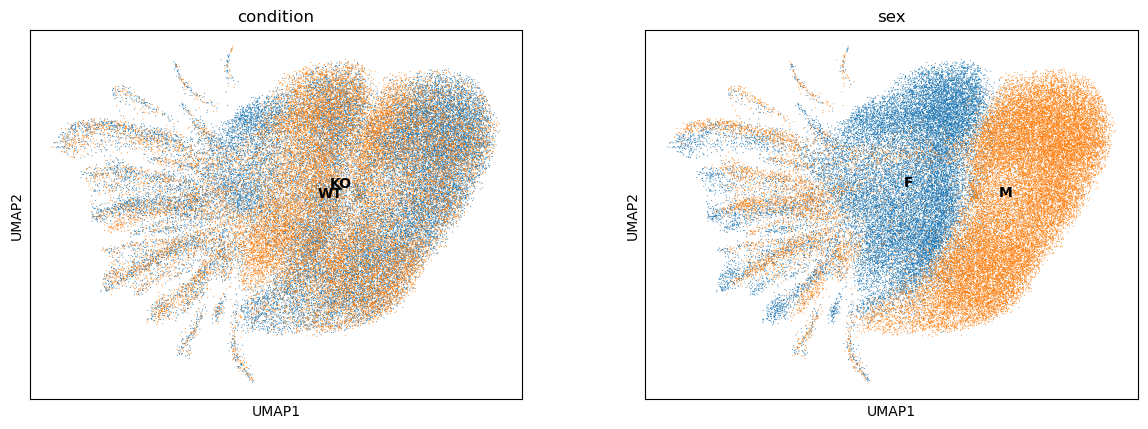

In [82]:
sc.pl.umap(adata, color=['condition', 'sex'], legend_loc='on data', show=False)

<Axes: title={'center': 'Δ ERCC1 KO cells'}, xlabel='UMAP1', ylabel='UMAP2'>

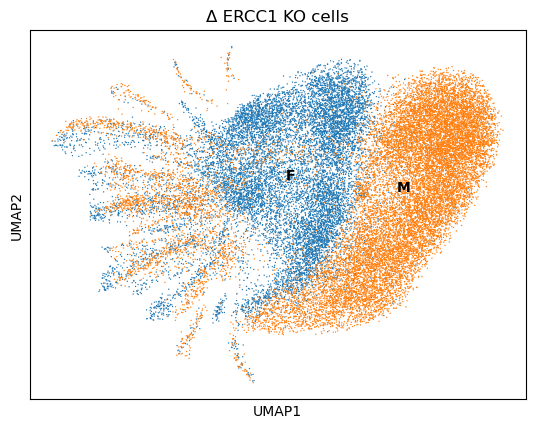

In [83]:
sc.pl.umap(adata[adata.obs['condition'] == 'KO'], color=['sex'], legend_loc='on data', show=False, title='Δ ERCC1 KO cells')

<Axes: title={'center': 'WT cells'}, xlabel='UMAP1', ylabel='UMAP2'>

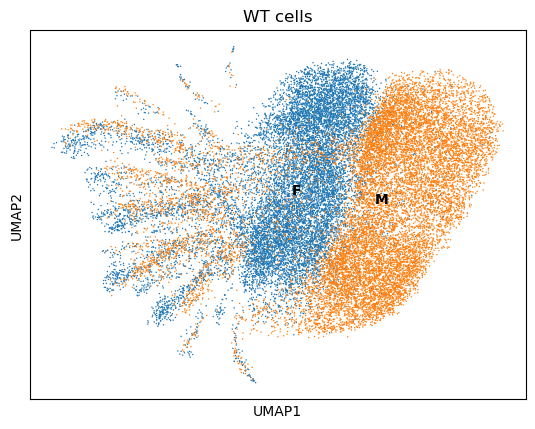

In [84]:
sc.pl.umap(adata[adata.obs['condition'] == 'WT'], color=['sex'], legend_loc='on data', show=False, title='WT cells')

# Cell population depletion/expansion analysis

#### Cells pooled from both sexes

In [ ]:
results_df = get_cell_type_percentages(adata)
results_df_by_sex = get_cell_type_percentages_by_sex(adata)


In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))
ax.axis('off')

# Create table with more space on the left
table = ax.table(cellText=results_df.values,
                colLabels=results_df.columns,
                cellLoc='center',
                loc='center',
                bbox=[0.2, 0, 0.95, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
# Make headers bold and remove their edges
for col in range(len(results_df.columns)):
    header_cell = table[(0, col)]
    header_cell.set_text_props(weight='bold')
    header_cell.set_edgecolor('none')  # Remove cell borders for headers
    header_cell.set_facecolor('none')  # Remove cell background for headers
# Reduce row height and column width
for cell in table._cells:
    table._cells[cell].set_height(0.05)
    if cell[1] in [1, 2]:
        table._cells[cell].set_width(0.15)
    else:
        table._cells[cell].set_width(0.25)

# Add colored dots with correct y-positions
num_rows = len(results_df)
for idx in range(num_rows):
    cell_type = results_df['Cell Type'].iloc[idx]
    
    # Calculate y position from top to bottom
    y_pos = 1 - ((idx + 1.5) / (num_rows + 1))
    
    ax.scatter(0.23,
              y_pos,
              c=[cell_type_colors.get(cell_type, 'black')],
              s=100,
              clip_on=False,
              zorder=1000)

# Set the plot limits explicitly to show the dots
ax.set_xlim(0.1, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# # Create figure and axis
# fig, ax = plt.subplots(figsize=(10, 5))  # Made wider to accommodate more columns
# ax.axis('off')
# # Create table with more space on the left
# table = ax.table(cellText=results_df_by_sex.values,
#                 colLabels=results_df_by_sex.columns,
#                 cellLoc='center',
#                 loc='center',
#                 bbox=[0.2, 0, 0.95, 1])

# # Style the table
# table.auto_set_font_size(False)
# table.set_fontsize(12)

# # Make headers bold
# for col in range(len(results_df_by_sex.columns)):
#     header_cell = table[(0, col)]
#     header_cell.set_text_props(weight='bold')
#     header_cell.set_edgecolor('none')  # Remove cell borders for headers
#     header_cell.set_facecolor('none')  # Remove cell background for headers

# # Reduce row height and adjust column widths
# # Reduce row height and column width
# for cell in table._cells:
#     table._cells[cell].set_height(0.05)
#     if cell[1] in [1, 2, 3, 4]:
#         table._cells[cell].set_width(0.15)
#     else:
#         table._cells[cell].set_width(0.25)

# # Add colored dots
# num_rows = len(results_df_by_sex)
# for idx in range(num_rows):
#     cell_type = results_df_by_sex['Cell Type'].iloc[idx]
#     y_pos = 1 - ((idx + 1.5) / (num_rows + 1))
    
#     ax.scatter(0.23,
#               y_pos,
#               c=[cell_type_colors.get(cell_type, 'black')],
#               s=100,
#               clip_on=False,
#               zorder=1000)

# ax.set_xlim(0.1, 1)
# ax.set_ylim(0, 1)
# plt.tight_layout()
# plt.show()

# [Analysis] Get the DEGs

In [85]:
adata.X = adata.layers['log1p_norm_cb']

In [86]:
# get the counts sum of genes starting with mt in different layers
mt_counts = adata.layers['counts'].toarray()[:, adata.var_names.str.startswith('mt-')]
mt_counts_cb = adata.layers['cellbender'].toarray()[:, adata.var_names.str.startswith('mt-')]
mt_counts_log1p_norm_cb = adata.layers['log1p_norm_cb'].toarray()[:, adata.var_names.str.startswith('mt-')]
print(mt_counts.sum())
print(mt_counts_cb.sum())
print(mt_counts_log1p_norm_cb.sum())

1789714.0
387763
137481.06


#### Filter non-nuclear genes

In [87]:
# For mouse data (based on your gene names):
adata.var['hb'] = adata.var_names.str.contains('^Hb[^(p)]', case=False)
adata.var['ribo'] = adata.var_names.str.contains('^Rp[sl]', case=False)
adata.var['mt'] = adata.var_names.str.contains('^mt-', case=False)

In [88]:
print("\nHemoglobin genes found:")
print(adata.var[adata.var['hb']].index.tolist())
print("Mitochondrial genes found:")
print(adata.var[adata.var['mt']].index.tolist())
print("Ribosomal genes found:")
print(adata.var[adata.var['ribo']].index.tolist())


Hemoglobin genes found:
['Hbb-bt', 'Hbb-bs', 'Hba-a1', 'Hba-a2']
Mitochondrial genes found:
['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb']
Ribosomal genes found:
['Rpl7', 'Rpl7a', 'Rps21', 'Rps3a1', 'Rpl34', 'Rps20', 'Rps6', 'Rps8', 'Rpl11', 'Rpl9', 'Rpl5', 'Rplp0', 'Rpl6', 'Rpl21', 'Rpl32', 'Rpl28', 'Rps5', 'Rps16', 'Rps11', 'Rpl13a', 'Rpl18', 'Rps17', 'Rps3', 'Rpl27a', 'Rplp2', 'Rpl18a', 'Rpl13', 'Rps25', 'Rplp1', 'Rpl29', 'Rpsa', 'Rpl14', 'Rps15', 'Rpl41', 'Rps26', 'Rps27a', 'Rpl26', 'Rpl23a', 'Rpl23', 'Rpl19', 'Rpl27', 'Rpl38', 'Rps7', 'Rps29', 'Rpl36al', 'Rps23', 'Rpl15', 'Rps24', 'Rpl37', 'Rpl30', 'Rpl8', 'Rpl35a', 'Rpl24', 'Rps2', 'Rps10', 'Rps28', 'Rpl17', 'Rpl39', 'Rps4x', 'Rpl36a']


In [89]:
# remove all genes that are encoded in mitochondrial DNA
adata = adata[:,(~adata.var['mt'] & ~adata.var['ribo']) & ~adata.var['hb']] # Filter mitochondrial, linc, ribosomal, haemoglobin genes

In [90]:
adata_male = adata[adata.obs['sex'] == 'M']
adata_female = adata[adata.obs['sex'] == 'F']

In [91]:
output_dir = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/scanpy_outs'
# Set scanpy settings
sc.settings.verbosity = 1
sc.settings.figdir = output_dir

In [92]:
# Analyze Male Cells
print("Analyzing Male Cells...")
adata_male_filtered, male_deg_results = perform_deg_analysis(
    adata_male, 
    condition_column='condition',
    reference='WT', 
    comparison='KO',
    sex_label='Male', #used for naming the files
    output_dir=output_dir,
    layer='log1p_norm_cb'
)

# Analyze Female Cells  
print("Analyzing Female Cells...")
adata_female_filtered, female_deg_results = perform_deg_analysis(
    adata_female,
    condition_column='condition',
    reference='WT',
    comparison='KO', 
    sex_label='Female',
    output_dir=output_dir,
    layer='log1p_norm_cb'
)

Analyzing Male Cells...
=== Performing DEG Analysis: Male KO vs WT ===
Available conditions: ['KO', 'WT']
Categories (2, object): ['KO', 'WT']
Cells in analysis - WT: 14595
Cells in analysis - KO: 18560
Total genes analyzed: 1923
Significantly upregulated genes (padj < 0.05, |log2FC| > 0.5): 224
Significantly downregulated genes (padj < 0.05, |log2FC| > 0.5): 103
Analyzing Female Cells...
=== Performing DEG Analysis: Female KO vs WT ===
Available conditions: ['KO', 'WT']
Categories (2, object): ['KO', 'WT']
Cells in analysis - WT: 13573
Cells in analysis - KO: 12994
Total genes analyzed: 1923
Significantly upregulated genes (padj < 0.05, |log2FC| > 0.5): 72
Significantly downregulated genes (padj < 0.05, |log2FC| > 0.5): 175


/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


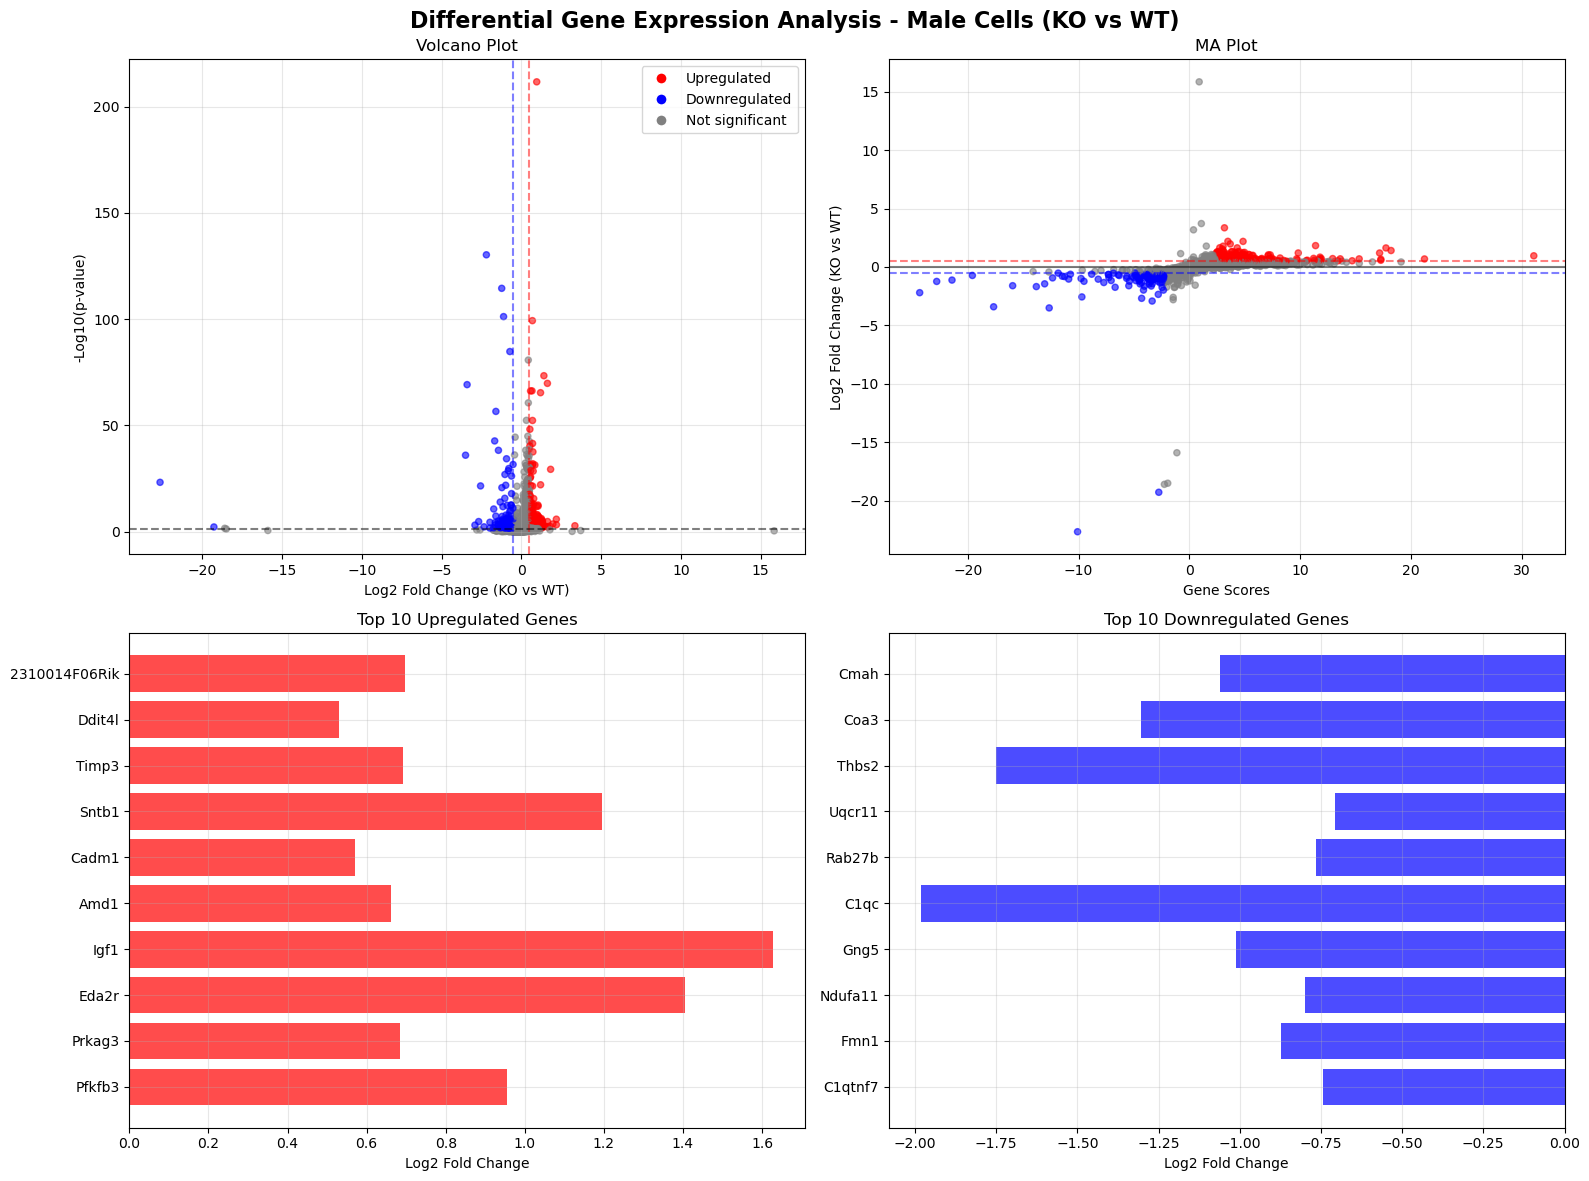

Visualization saved at: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/scanpy_outs/DEG_analysis_male.png


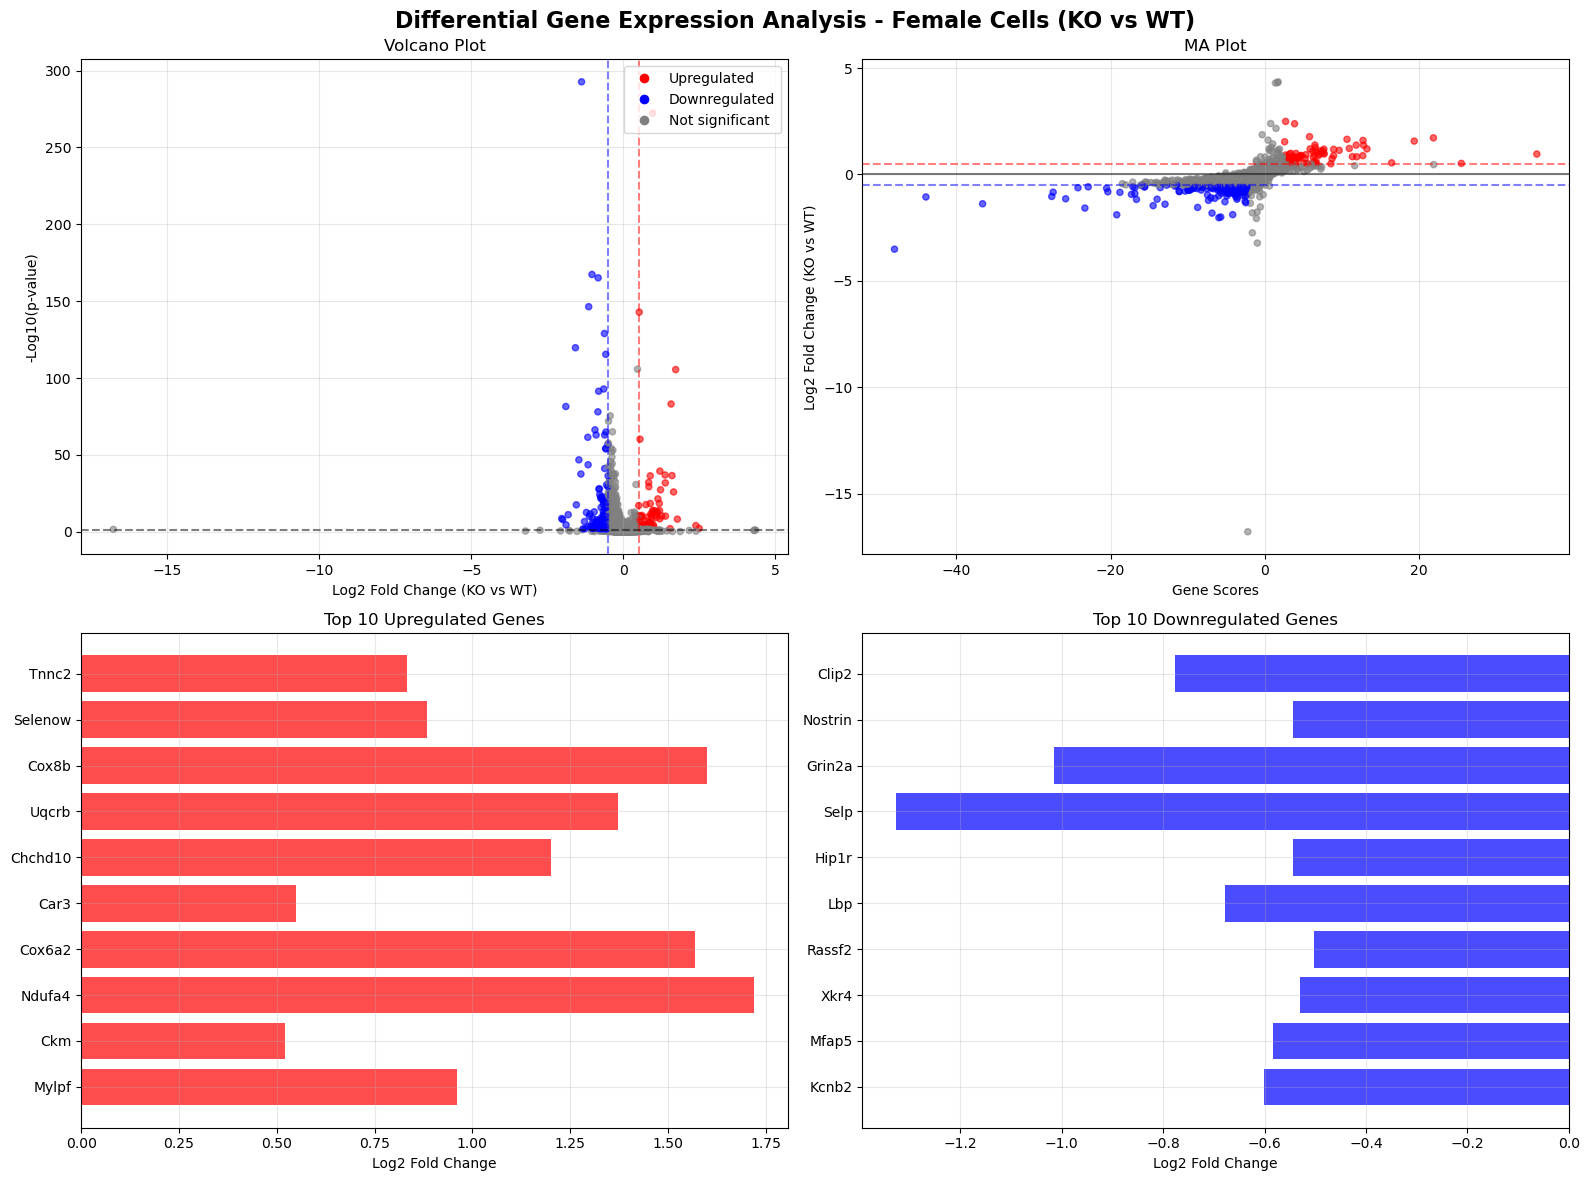

Visualization saved at: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/scanpy_outs/DEG_analysis_female.png


In [93]:
# Visualize and Save Results
if male_deg_results is not None:
    visualize_deg_results(male_deg_results, 'Male', output_dir)

if female_deg_results is not None:
    visualize_deg_results(female_deg_results, 'Female', output_dir)

In [94]:
# save to csv
save_deg_results(male_deg_results, 'Male', output_dir)
save_deg_results(female_deg_results, 'Female', output_dir)


Significant DEG results saved at: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/scanpy_outs/DEG_results_male_up.csv
Significant DEG results saved at: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/scanpy_outs/DEG_results_male_down.csv
Significant DEG results saved at: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/scanpy_outs/DEG_results_female_up.csv
Significant DEG results saved at: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/scanpy_outs/DEG_results_female_down.csv


,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,log2FC,-log10(pval),significant
1922,Nr4a3,-48.038315,-3.507500,0.000000e+00,0.000000e+00,0.035093,-3.507500,inf,True
1921,Nr4a1,-43.959881,-1.055059,0.000000e+00,0.000000e+00,0.444898,-1.055059,inf,True
1920,Slc25a25,-36.607624,-1.375503,2.163053e-293,1.386517e-290,0.161074,-1.375503,292.664933,True
0,Mylpf,35.306202,0.960373,4.717063e-273,2.267728e-270,0.754117,0.960373,272.326328,True
1919,Ppargc1a,-27.632906,-1.031969,4.479261e-168,1.722724e-165,0.430660,-1.031969,167.348794,True
...,...,...,...,...,...,...,...,...,...
1259,Lbp,-2.432206,-0.677422,1.500716e-02,3.733346e-02,0.003694,-0.677422,1.823702,True
1254,Rassf2,-2.398195,-0.501841,1.647610e-02,4.056792e-02,0.005233,-0.501841,1.783146,True
1253,Xkr4,-2.392362,-0.530202,1.674033e-02,4.116580e-02,0.004387,-0.530202,1.776236,True
1245,Mfap5,-2.363606,-0.583383,1.809802e-02,4.399810e-02,0.008158,-0.583383,1.742369,True


In [95]:
if male_deg_results is not None and female_deg_results is not None:
    # Get significant genes with their regulation direction
    male_sig = male_deg_results[male_deg_results['significant']].copy()
    female_sig = female_deg_results[female_deg_results['significant']].copy()
    
    # Separate by regulation direction
    male_up = set(male_sig[male_sig['logfoldchanges'] > 0]['names'])
    male_down = set(male_sig[male_sig['logfoldchanges'] < 0]['names'])
    female_up = set(female_sig[female_sig['logfoldchanges'] > 0]['names'])
    female_down = set(female_sig[female_sig['logfoldchanges'] < 0]['names'])
    
    # Find common and sex-specific DEGs by regulation direction
    common_up = male_up.intersection(female_up)
    common_down = male_down.intersection(female_down)
    male_specific_up = male_up - female_up
    male_specific_down = male_down - female_down
    female_specific_up = female_up - male_up
    female_specific_down = female_down - male_down
    
    print(f"\n=== COMPARISON SUMMARY BY REGULATION ===")
    print(f"Common up-regulated DEGs: {len(common_up)}")
    print(f"Common down-regulated DEGs: {len(common_down)}")
    print(f"Male-specific up-regulated DEGs: {len(male_specific_up)}")
    print(f"Male-specific down-regulated DEGs: {len(male_specific_down)}")
    print(f"Female-specific up-regulated DEGs: {len(female_specific_up)}")
    print(f"Female-specific down-regulated DEGs: {len(female_specific_down)}")
    
    # Create DataFrame with gene names as rows
    # Find the maximum length to determine DataFrame size
    max_length = max(len(common_up), len(common_down), 
                    len(male_specific_up), len(male_specific_down),
                    len(female_specific_up), len(female_specific_down))
    
    # Create DataFrame with NaN padding
    comparison_df = pd.DataFrame({
        'common_up': list(common_up) + [np.nan] * (max_length - len(common_up)),
        'common_down': list(common_down) + [np.nan] * (max_length - len(common_down)),
        'male_specific_up': list(male_specific_up) + [np.nan] * (max_length - len(male_specific_up)),
        'male_specific_down': list(male_specific_down) + [np.nan] * (max_length - len(male_specific_down)),
        'female_specific_up': list(female_specific_up) + [np.nan] * (max_length - len(female_specific_up)),
        'female_specific_down': list(female_specific_down) + [np.nan] * (max_length - len(female_specific_down))
    })
    
    # Save the detailed comparison results
    comparison_file = 'DEG_sex_comparison_detailed.csv'
    comparison_df.to_csv(os.path.join(output_dir, comparison_file), index=False)
    print(f"Detailed sex comparison results saved at: {comparison_file}")
    
    # Also create a summary DataFrame
    summary_df = pd.DataFrame({
        'Category': ['Common up-regulated', 'Common down-regulated', 
                    'Male-specific up-regulated', 'Male-specific down-regulated',
                    'Female-specific up-regulated', 'Female-specific down-regulated'],
        'Count': [len(common_up), len(common_down), 
                 len(male_specific_up), len(male_specific_down),
                 len(female_specific_up), len(female_specific_down)]
    })


=== COMPARISON SUMMARY BY REGULATION ===
Common up-regulated DEGs: 5
Common down-regulated DEGs: 20
Male-specific up-regulated DEGs: 219
Male-specific down-regulated DEGs: 83
Female-specific up-regulated DEGs: 67
Female-specific down-regulated DEGs: 155
Detailed sex comparison results saved at: DEG_sex_comparison_detailed.csv


In [119]:
# get a ranked genelist for pathway analysis
male_ranked_degs = create_ranked_genelist(male_deg_results, log2fc_col='logfoldchanges', pval_col='pvals_adj', gene_col='names', min_pval=1e-300)
female_ranked_degs = create_ranked_genelist(female_deg_results, log2fc_col='logfoldchanges', pval_col='pvals_adj', gene_col='names', min_pval=1e-300)
print(male_ranked_degs)


names              Pfkfb3        Igf1      Eda2r      Sntb1     Prkag3  \
ranking_score  199.252177  109.785568  99.875752  75.615147  66.298167   

names              Ostn       Amd1      Cadm1      Timp3      Fmnl2  ...  \
ranking_score  50.76589  42.357098  36.623849  34.842807  33.570324  ...   

names            Selenow      Myh1     Cebpb    Gadd45g       Nr4a1  \
ranking_score -52.604293 -59.76647 -68.42854 -87.372765 -110.476657   

names                Mt1        Pdk4       Nr4a3    Slc25a25         Mt2  
ranking_score -119.88388 -138.264932 -228.039083 -279.948216 -493.488425  

[1 rows x 1923 columns]


## Load pre-calculated DEGs

In [ ]:
# ########## file paths ##########
# output_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/pathways"
# #fast2b
# female_fast2b_path = os.path.join(working_dir, "Female_FastIIB_unfiltered_KO_DEGs.csv")
# male_fast2b_path = os.path.join(working_dir, "Male_Fast IIB_unfiltered_KO_DEGs_nmt.csv")
# #fast2x
# female_fast2x_path = os.path.join(working_dir, "Female_FastIIX_unfiltered_KO_DEGs.csv")
# male_fast2x_path = os.path.join(working_dir, "Male_Fast IIX_unfiltered_KO_DEGs_nmt.csv")
# # #faps
# # female_faps_path = os.path.join(working_dir, "Female_FAPs_unfiltered_KO_DEGs_nmt.csv")
# # male_faps_path = os.path.join(working_dir, "Male_FAPs_unfiltered_KO_DEGs_nmt.csv")
# # #musc
# # female_musc_path = os.path.join(working_dir, "Female_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")
# # male_musc_path = os.path.join(working_dir, "Male_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")


In [ ]:
# ############ load cell-type specific DEGs ############

# path_female_degs = female_fast2b_path
# path_male_degs = male_fast2b_path
# female_degs = pd.read_csv(path_female_degs, header=0)
# female_degs.rename(columns={female_degs.columns[0]: 'gene_name'}, inplace=True)
# male_degs = pd.read_csv(path_male_degs, header=0)
# male_degs.rename(columns={male_degs.columns[0]: 'gene_name'}, inplace=True)

In [ ]:
# gsea_female_degs = create_ranked_genelist(female_degs)
# gsea_male_degs = create_ranked_genelist(male_degs)

## Load the genesets of interest (mouse)

In [102]:
# load msigDB all genesets for mice
msigdb_mice_gmt = "/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/msigdb.v2024.1.Mm.symbols.gmt"
mhallmark_gmt = "/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/mh.all.v2024.1.Mm.symbols.gmt"

In [103]:
msigdb_mice = gmt_to_decoupler(msigdb_mice_gmt)
mhallmark = gmt_to_decoupler(mhallmark_gmt)
# Count unique genesets
n_unique_genesets = msigdb_mice['geneset'].nunique()
n_unique_genesets_mhallmark = mhallmark['geneset'].nunique()
print(f"Number of unique genesets: {n_unique_genesets}")
print(f"Number of unique genesets: {n_unique_genesets_mhallmark}")

Number of unique genesets: 16059
Number of unique genesets: 50


In [104]:
# Filtering genesets to match behaviour of fgsea
geneset_size = msigdb_mice.groupby("geneset").size()
geneset_size_mhallmark = mhallmark.groupby("geneset").size()
# Index object of genesets that have more than 15 and less than 500 genes
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]
gsea_genesets_mhallmark = geneset_size_mhallmark.index[(geneset_size_mhallmark > 15) & (geneset_size_mhallmark < 500)]

### Select Pathways related to mitochondrial function

In [ ]:
# Create a list of keywords you're interested in
keywords = [
    'OXIDATIVE_PHOSPHORYLATION',      # For oxidative phosphorylation
    'TCA',         # For TCA cycle
    'GLUTAMINE',   # For glutamine metabolism
    'CALCIUM',     # For calcium signaling
    'APOPTOSIS'    # For apoptosis
]

selected_pathways = [
    pathway for pathway in gsea_genesets
    if any(keyword.lower() in pathway.lower() for keyword in keywords)
]

display(len(selected_pathways))

In [ ]:
# find the geneset that contains the gene 'Atp2a1'
serca_genesets = []
for geneset in selected_pathways:
    if 'Atp2a1' in msigdb_mice[msigdb_mice['geneset'] == geneset]['genesymbol'].values:
        serca_genesets.append(geneset)
        break

display(serca_genesets)

#### Run gsea

In [124]:
scores, norm, pvals = dc.run_gsea(
    male_ranked_degs,
    mhallmark,
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)
display(gsea_results.head())

,score,norm,pval
source,,,
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.789259,1.480536,0.011272
HALLMARK_ADIPOGENESIS,0.844515,1.445883,0.024279
HALLMARK_G2M_CHECKPOINT,0.926700,1.362618,0.039295
HALLMARK_OXIDATIVE_PHOSPHORYLATION,-0.910829,-1.511585,0.048701
HALLMARK_MITOTIC_SPINDLE,0.770939,1.330124,0.077035


In [125]:
# First prepare your data
# gsea_results = gsea_results[~gsea_results.index.str.startswith('WP')]
gsea_results['-log10(pval)'] = -np.log10(gsea_results['pval'].replace(0, 1e-300))
gsea_results['Group'] = gsea_results['score'].apply(lambda x: 'Up' if x > 0 else 'Down')
# Create a copy with reset index to get the pathway names as a column
plot_df = gsea_results.reset_index().copy()
plot_df[['Gene_set', 'Name']] = plot_df['source'].str.extract(r'(GOBP|REACTOME|KEGG|HALLMARK|GOMF|GOCC|GRAESSMANN|WP)_(.+)')
plot_df['Name'] = plot_df['Name'].apply(lambda x: '_'.join(x.split('_')[:6]))
plot_df = plot_df.loc[plot_df.groupby('Name')['-log10(pval)'].idxmax()]
# copy source column to a new column called 'Term'
plot_df['Term'] = plot_df['source']
display(plot_df.head())


,source,score,norm,pval,-log10(pval),Group,Gene_set,Name,Term
1,HALLMARK_ADIPOGENESIS,0.844515,1.445883,0.024279,1.614765,Up,HALLMARK,ADIPOGENESIS,HALLMARK_ADIPOGENESIS
45,HALLMARK_ALLOGRAFT_REJECTION,-0.298130,-0.477712,0.996454,0.001543,Down,HALLMARK,ALLOGRAFT_REJECTION,HALLMARK_ALLOGRAFT_REJECTION
22,HALLMARK_ANDROGEN_RESPONSE,0.607858,0.996043,0.525926,0.279075,Up,HALLMARK,ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE
36,HALLMARK_ANGIOGENESIS,-0.458324,-0.725506,0.750000,0.124939,Down,HALLMARK,ANGIOGENESIS,HALLMARK_ANGIOGENESIS
41,HALLMARK_APICAL_JUNCTION,-0.404084,-0.680431,0.853403,0.068846,Down,HALLMARK,APICAL_JUNCTION,HALLMARK_APICAL_JUNCTION


## Plotting the enrichment results

In [126]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap()

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/gseapy/plot.py:753: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))


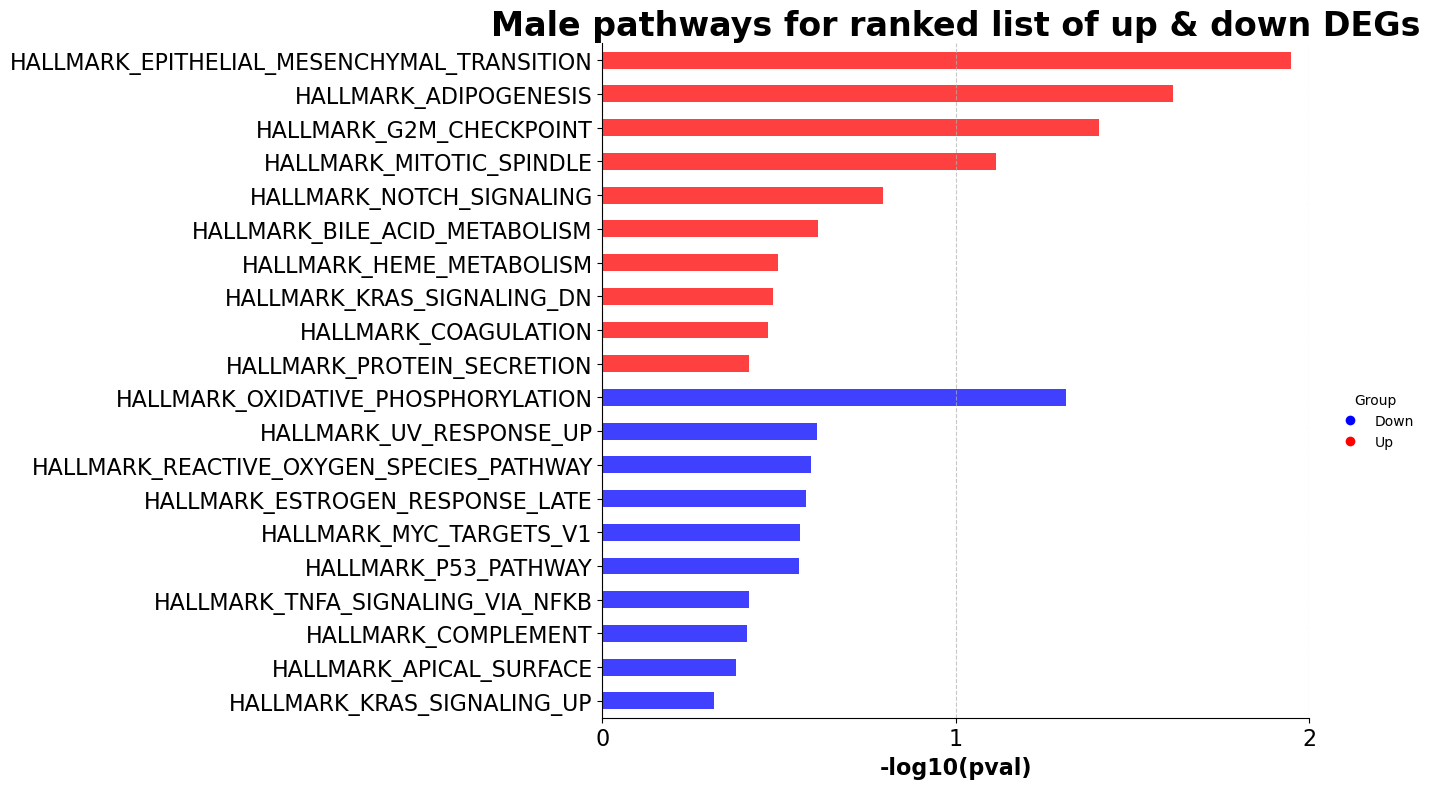

In [127]:
# Create simplified terms and group by them
plot_df['simple_term'] = plot_df['Term'].apply(simplify_term)
# Keep only the most significant pathway for each simplified term
plot_df = plot_df.loc[plot_df.groupby('simple_term')['-log10(pval)'].idxmax()]
# Sort to put Up group at top
plot_df = plot_df.sort_values(['Group', '-log10(pval)'], ascending=[True, False])

ax = gp.barplot(
    df=plot_df,
    column='-log10(pval)',
    group='Group',
    title='Male pathways for ranked list of up & down DEGs',
    color={'Up': 'red', 'Down': 'blue'},
    cutoff=2.0,
    figsize=(14, 8)
)

# Set x-axis limits and ticks
ax.set_xlim(0, 2)  # Fixed limit to 2.5
ax.set_xticks([0, 1, 2])  # Only show 0, 1, and 2
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(left=0.4)
plt.show()

In [ ]:
cutoff_for_plotting_data = plot_df[plot_df['-log10(pval)'] <= 2][['Term', 'Group', '-log10(pval)']]
top_paths = (cutoff_for_plotting_data.groupby('Group')
            .apply(lambda x: x.nlargest(min(10, len(x)), '-log10(pval)'))
            .reset_index(drop=True))

# Sort by Group (to keep Up on top) and then by -log10(pval)
top_paths = top_paths.sort_values(['Group', '-log10(pval)'], ascending=[True, False])
display(top_paths)
